In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install trimesh


In [ ]:
import os

DATA_DIR = "/kaggle/input/mugs-normalised/mugs_normalized"
print(os.listdir(DATA_DIR))


In [ ]:
import trimesh

mesh = trimesh.load(f"{DATA_DIR}/mug1.obj")
mesh.show()


In [ ]:
import numpy as np

# I am sampling points in the bounding box of the mesh
bounds = mesh.bounds
points = np.random.uniform(
    low=bounds[0],
    high=bounds[1],
    size=(50000, 3)
)

points.shape


In [ ]:
sdf = trimesh.proximity.signed_distance(mesh, points)

sdf.shape


In [ ]:
import matplotlib.pyplot as plt

inside = sdf < 0
outside = sdf > 0

plt.figure(figsize=(6,6))
plt.scatter(points[outside][:,0], points[outside][:,1],
            s=1, c='red', label='outside')
plt.scatter(points[inside][:,0], points[inside][:,1],
            s=1, c='blue', label='inside')

plt.legend()
plt.axis('equal')
plt.title("Signed Distance Field Sampling")
plt.show()


In [ ]:
import os
import pickle

DATA_DIR = "/kaggle/input/mugs-normalised/mugs_normalized"

all_sdf = {}

for fname in os.listdir(DATA_DIR):
    if not fname.endswith(".obj"):
        continue   

    mesh = trimesh.load(os.path.join(DATA_DIR, fname))
    pts = np.random.uniform(mesh.bounds[0], mesh.bounds[1], (30000, 3))
    sdf_vals = trimesh.proximity.signed_distance(mesh, pts)

    all_sdf[fname] = {
        "points": pts,
        "sdf": sdf_vals
    }

print("Processed objects:", len(all_sdf))


In [ ]:
with open("all_mugs_sdf.pkl", "wb") as f:
    pickle.dump(all_sdf, f)

#Day2 : DeepSDF training to get the latent vector(z) by backprop.

In [3]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [5]:
with open("/kaggle/input/mugs-sdf-data/all_mugs_sdf.pkl", "rb") as f:
    all_sdf = pickle.load(f)

object_names = sorted(all_sdf.keys())
num_objects = len(object_names)

print("Objects:", object_names)
print("Number of objects:", num_objects)

Objects: ['mug1.obj', 'mug2.obj', 'mug3.obj', 'mug4.obj', 'mug5.obj', 'mug6.obj', 'mug7.obj', 'mug8.obj', 'mug9.obj']
Number of objects: 9


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
LATENT_DIM = 64

latent_codes = nn.Embedding(num_objects, LATENT_DIM).to(device)
nn.init.normal_(latent_codes.weight, mean=0.0, std=0.01)

Parameter containing:
tensor([[-0.0074,  0.0059,  0.0181,  0.0043,  0.0011, -0.0013,  0.0133, -0.0027,
         -0.0032, -0.0126,  0.0173,  0.0013, -0.0064,  0.0043,  0.0073,  0.0068,
          0.0065, -0.0008,  0.0106,  0.0129, -0.0019,  0.0046,  0.0115,  0.0091,
         -0.0228, -0.0145,  0.0087,  0.0064, -0.0036, -0.0048,  0.0138,  0.0037,
          0.0048, -0.0153,  0.0084, -0.0236, -0.0141,  0.0027,  0.0046,  0.0203,
          0.0114,  0.0091, -0.0049, -0.0002,  0.0083, -0.0093, -0.0111, -0.0020,
         -0.0018,  0.0086,  0.0100,  0.0109, -0.0030, -0.0065,  0.0048,  0.0018,
         -0.0042,  0.0090, -0.0051,  0.0087,  0.0102,  0.0010, -0.0009,  0.0081],
        [-0.0176, -0.0006, -0.0041, -0.0177, -0.0142,  0.0157, -0.0065, -0.0030,
         -0.0080,  0.0222,  0.0030,  0.0014, -0.0120,  0.0057,  0.0035, -0.0036,
         -0.0026, -0.0004, -0.0033, -0.0072,  0.0037, -0.0086,  0.0305,  0.0355,
         -0.0080,  0.0183, -0.0284, -0.0152,  0.0073, -0.0053,  0.0204,  0.0115,
     

In [9]:
class DeepSDF(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim + 3, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 1)

    def forward(self, x, z):
        h = torch.cat([x, z], dim=1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc4(h)

In [10]:
model = DeepSDF(LATENT_DIM).to(device)

In [11]:
def sdf_loss(pred, gt):
    return torch.mean(torch.abs(pred - gt))

In [13]:
#L2 regularization
def latent_reg(z):
    return torch.mean(z.pow(2))

In [14]:
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(latent_codes.parameters()),
    lr=1e-4
)

In [21]:
EPOCHS = 150
SAMPLES_PER_OBJECT = 2048
LAMBDA_LATENT = 1e-4

In [22]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=1e-6
)

In [23]:
for epoch in range(EPOCHS):
    total_loss = 0.0
    total_recon = 0.0
    total_reg = 0.0

    for obj_idx, name in enumerate(object_names):
        data = all_sdf[name]

        # Load data
        points = torch.tensor(
            data["points"], dtype=torch.float32, device=device
        )
        sdf_gt = torch.tensor(
            data["sdf"], dtype=torch.float32, device=device
        ).unsqueeze(1)

        # Random subsampling
        idx = torch.randperm(len(points))[:SAMPLES_PER_OBJECT]
        points = points[idx]
        sdf_gt = sdf_gt[idx]

        # Latent code for this object
        z = latent_codes(
            torch.tensor([obj_idx], device=device)
        ).repeat(len(points), 1)

        # Forward pass
        pred_sdf = model(points, z)

        # Reconstruction loss (L1)
        recon_loss = torch.mean(torch.abs(pred_sdf - sdf_gt))

        # Latent regularization (L2)
        reg_loss = torch.mean(z.pow(2))

        # Total loss
        loss = recon_loss + LAMBDA_LATENT * reg_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate losses
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_reg += reg_loss.item()

    # Update learning rate (cosine annealing)
    scheduler.step()

    # Logging
    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        print(
            f"Epoch {epoch:03d} | "
            f"Total Loss: {total_loss:.4f} | "
            f"Recon: {total_recon:.4f} | "
            f"Latent Reg: {total_reg:.4f} | "
            f"LR: {scheduler.get_last_lr()[0]:.6f}"
        )


Epoch 000 | Total Loss: 0.2248 | Recon: 0.2248 | Latent Reg: 0.0015 | LR: 0.000001
Epoch 010 | Total Loss: 0.2260 | Recon: 0.2260 | Latent Reg: 0.0015 | LR: 0.000001
Epoch 020 | Total Loss: 0.2220 | Recon: 0.2220 | Latent Reg: 0.0015 | LR: 0.000001
Epoch 030 | Total Loss: 0.2236 | Recon: 0.2236 | Latent Reg: 0.0015 | LR: 0.000001
Epoch 040 | Total Loss: 0.2224 | Recon: 0.2224 | Latent Reg: 0.0015 | LR: 0.000001
Epoch 050 | Total Loss: 0.2205 | Recon: 0.2205 | Latent Reg: 0.0015 | LR: 0.000001
Epoch 060 | Total Loss: 0.2193 | Recon: 0.2193 | Latent Reg: 0.0015 | LR: 0.000001
Epoch 070 | Total Loss: 0.2202 | Recon: 0.2202 | Latent Reg: 0.0015 | LR: 0.000001
Epoch 080 | Total Loss: 0.2193 | Recon: 0.2193 | Latent Reg: 0.0015 | LR: 0.000001
Epoch 090 | Total Loss: 0.2182 | Recon: 0.2182 | Latent Reg: 0.0015 | LR: 0.000001
Epoch 100 | Total Loss: 0.2163 | Recon: 0.2163 | Latent Reg: 0.0015 | LR: 0.000001
Epoch 110 | Total Loss: 0.2192 | Recon: 0.2192 | Latent Reg: 0.0015 | LR: 0.000001
Epoc

In [26]:
# Save trained DeepSDF model and latent codes
checkpoint = {
    "model_state_dict": model.state_dict(),
    "latent_codes_state_dict": latent_codes.state_dict(),
    "latent_dim": LATENT_DIM,
    "num_objects": num_objects,
    "object_names": object_names
}

torch.save(checkpoint, "/kaggle/working/deepsdf_day2_checkpoint.pth")

print("Model saved to /kaggle/working/deepsdf_day2_checkpoint.pth")


Model saved to /kaggle/working/deepsdf_day2_checkpoint.pth


In [24]:
# Pick one object
obj_idx = 0
name = object_names[obj_idx]
data = all_sdf[name]

# Random test points
pts = torch.tensor(
    data["points"][:5000], dtype=torch.float32, device=device
)

# Latent code
z = latent_codes(
    torch.tensor([obj_idx], device=device)
).repeat(len(pts), 1)

# Predict SDF
with torch.no_grad():
    pred_sdf = model(pts, z).cpu().numpy()


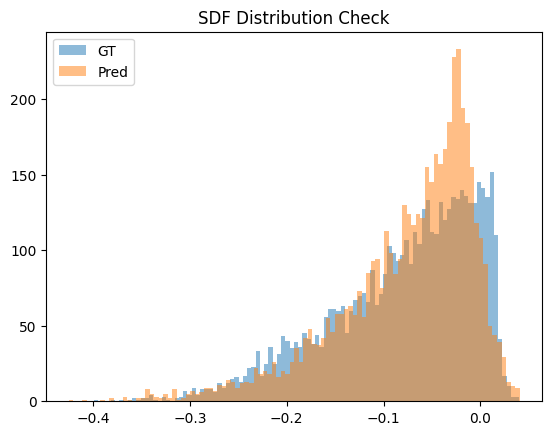

In [25]:
import matplotlib.pyplot as plt

plt.hist(data["sdf"][:5000], bins=100, alpha=0.5, label="GT")
plt.hist(pred_sdf.flatten(), bins=100, alpha=0.5, label="Pred")
plt.legend()
plt.title("SDF Distribution Check")
plt.show()
